In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv, json
import pandas as pd
import scipy.optimize as sp
import itertools

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG_class.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py

In [4]:
run_dir = "gap_scaling_pass2/"

log_file = pd.read_csv(run_dir+"log_file.csv")
ts_list = log_file['ts'].tolist()
#log_file['L'].tolist()
selected_files = log_file
selected_files

ts_list = selected_files['ts'].tolist()
n_runs_list = selected_files['n_runs'].tolist()
L_list = selected_files['L'].tolist()

selected_files

,L,steps,a,b,w,n_runs,ts
0,10,99,0.1,0.105,6.3,960,983498441063.01.0
1,10,99,0.1,0.105,6.4,960,983583251064.01.0
2,10,99,0.1,0.105,6.5,960,983621221065.01.0
3,10,99,0.1,0.105,6.6,960,985675531066.01.0
4,10,99,0.1,0.105,6.7,960,985675531067.01.0
5,10,99,0.1,0.105,6.8,960,985714541068.01.0
6,10,99,0.1,0.105,6.9,960,985714551069.01.0
7,20,399,0.1,0.105,6.3,960,985750852063.01.0
8,20,399,0.1,0.105,6.4,960,985752282064.01.0
9,20,399,0.1,0.105,6.5,960,985843672065.01.0


In [5]:
def output_reader(measure_list, fname):
    J_dist_dict = [{} for _ in range(len(measure_list))]
    h_dist_dict = [{} for _ in range(len(measure_list))]

    #In1629_J_m3571
    with open(fname, 'r') as reader:
        next(reader)
        for line in reader:
            marker_end = line.find('[')
            if line[6]=='_': inst_end = 6
            elif line[7]=='_': inst_end = 7
            else: print("Read error")
            inst_num = int(line[2:inst_end])
            coupling_type = line[inst_end+1:inst_end+2]
            if coupling_type=='r':continue
            measure_ind = np.where(measure_list==1+int(line[inst_end+4:marker_end]))[0][0]
            try:
                couplings = np.array(json.loads(line[marker_end:]))
            except:
                print("Corrupted file")
            if coupling_type == 'h':
                h_dist_dict[measure_ind][inst_num] = couplings
            elif coupling_type == 'J':
                J_dist_dict[measure_ind][inst_num] = couplings
    
    return [h_dist_dict, J_dist_dict]

def unpack_dictionaries(file_out, measure_list):
    h_dist_dict, J_dist_dict = file_out
    h_dist_list, J_dist_list = [], []
    
    for i in range(len(measure_list)):
        h_dist_list.append(np.concatenate(tuple(h_dist_dict[i].values())))
        J_dist_list.append(np.concatenate(tuple(J_dist_dict[i].values())))
        
    return h_dist_list, J_dist_list

In [152]:
def linear_fit(x, a ,b):
    return x*a + b


L_list = [60, 80]
free_spins_L = []
intercept_list_L = []
slope_list_L = []

for L in L_list:
    fixed_length_slice = log_file[log_file['L']==L]
    ts_list = np.array(fixed_length_slice['ts'].tolist())
    n_bins_h, n_bins_J = 50, 50
    free_spins_comp = []
    intercept_list_comp = []
    slope_list_comp = []
    marker_list = []

    for index,ts in enumerate(ts_list):

        with open(run_dir+"LIsing_2D_input_"+str(ts)+".pkl", "rb") as fp:   
            input_dict = pickle.load(fp)

        measure_list = input_dict['measure_list']
        fname = run_dir+"LIsing_2D_output_"+str(ts)+".txt"

        h_dist_dict, J_dist_dict = output_reader(measure_list, fname)

        h_dist_list,J_dist_list = [], []
        for i in range(len(measure_list)-1):
            h_dist_list.append(np.concatenate(tuple(h_dist_dict[i].values())))
            J_dist_list.append(np.concatenate(tuple(J_dist_dict[i].values())))

        spins_left = L*L - measure_list

        intercept_list = []
        slope_list = []
        free_spins = []

        for i,step in enumerate(spins_left[:-1]): 

            n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
            width = bins[1]-bins[0]
            x = (bins[1:]-width/2)
            y = n
            popt, pcov = curve_fit(exponential_dist_norm, x[1:5], y[1:5])
            R0_width = 1/popt[0]

            n,bins = np.histogram(J_dist_list[i], bins = n_bins_J)
            width = bins[1]-bins[0]
            x = (bins[1:]-width/2)/R0_width
            y = n/step/width/input_dict['n_runs']/2

            popt, pcov = curve_fit(linear_fit, x[1:], y[1:])
            slope_list.append(popt[0])
            intercept_list.append(popt[1])
            free_spins.append(step)

        free_spins_comp.append(free_spins)
        slope_list_comp.append(slope_list)
        intercept_list_comp.append(intercept_list)
    free_spins_L.append(free_spins_comp)
    slope_list_L.append(slope_list_comp)
    intercept_list_L.append(intercept_list_comp)

In [170]:
80*80*0.2

1280.0

Text(0, 0.5, 'Slope parameter')

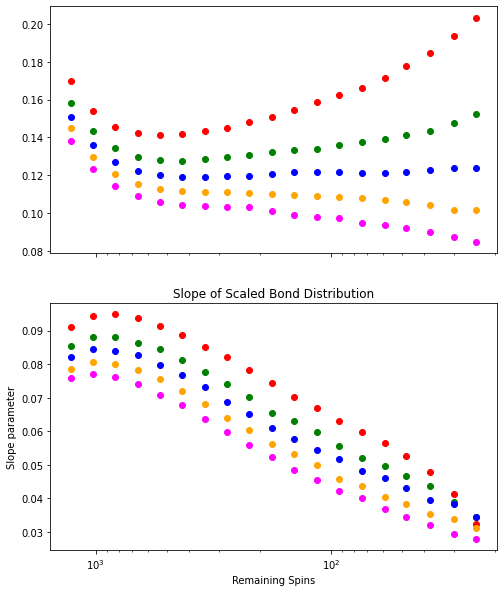

In [167]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
w_vals = fixed_length_slice['w'].tolist()
#plt.figure(figsize=(8, 6))

for index,ts in enumerate(ts_list):
    if index%2==0: continue
    axs[0].scatter(free_spins_comp[index], intercept_list_comp[index], label=str(w_vals[index]))
    axs[1].scatter(free_spins_comp[index], slope_list_comp[index])
    #plt.scatter(free_spins_comp[index], slope_list_comp[index], label="Width="+str(round(w_vals[index],2)))
plt.gca().invert_xaxis()
plt.xscale('log')
#plt.yscale('log')
plt.title("Slope of Scaled Bond Distribution")
plt.xlabel("Remaining Spins")
plt.ylabel("Slope parameter")
#plt.scatter(L*L, 0.1, marker='^')
#axs[0].legend()

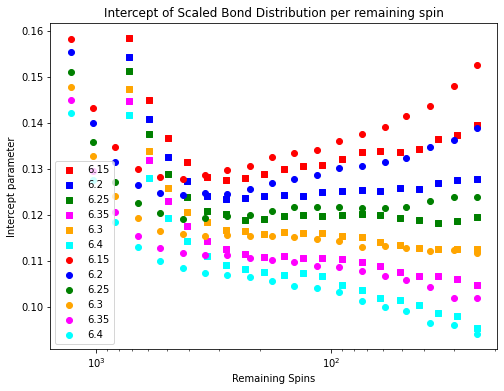

In [166]:
plt.figure(figsize=(8, 6))
marker_dict= {80:'o', 50:'^', 60:'s'}

w_c_dict = {6.15:'red', 6.2:'blue', 6.25:'green', 6.3:'orange', 6.35:'magenta', 6.4:'cyan'}

for ind, L in enumerate(L_list):
    fixed_length_slice = log_file[log_file['L']==L]
    w_vals = fixed_length_slice['w'].tolist()
    for index,ts in enumerate(ts_list):
        #if marker_list[index] != 'x': continue
        if not (w_vals[index]>6.1 and w_vals[index]<6.45): continue
        plt.scatter(free_spins_L[ind][index], intercept_list_L[ind][index], label=str(w_vals[index]), marker=marker_dict[L], c=w_c_dict[w_vals[index]])
        #plt.scatter(free_spins_comp[index], slope_list_comp[index], label=str(w_vals[index]))
        #plt.scatter(free_spins_comp[index], slope_list_comp[index], label="Width="+str(round(w_vals[index],2)))
plt.gca().invert_xaxis()
plt.xscale('log')
plt.legend()
#plt.yscale('log')
plt.title("Intercept of Scaled Bond Distribution per remaining spin")
plt.xlabel("Remaining Spins")
plt.ylabel("Intercept parameter")
plt.savefig("Zeta_dist_intercept_2")

[  2.34052677 -12.31525326]


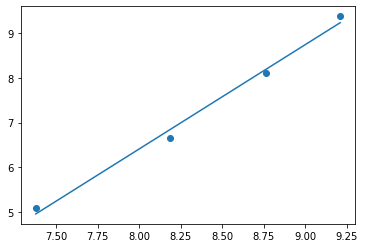

In [22]:
plt.figure(figsize=(8, 6))
marker_dict= {40:'o', 50:'^', 60:'s'}

for ind, L in enumerate(L_list):
    fixed_length_slice = log_file[log_file['L']==L]
    w_vals = fixed_length_slice['w'].tolist()
    for index,ts in enumerate(ts_list):
        #if marker_list[index] != 'x': continue
        if not (w_vals[index]>5.7 and w_vals[index]<6.7): continue
        plt.scatter(free_spins_L[ind][index], intercept_list_L[ind][index], label=str(w_vals[index]), marker=marker_dict[L])
        #plt.scatter(free_spins_comp[index], slope_list_comp[index], label=str(w_vals[index]))
        #plt.scatter(free_spins_comp[index], slope_list_comp[index], label="Width="+str(round(w_vals[index],2)))
plt.gca().invert_xaxis()
plt.xscale('log')
plt.legend()
#plt.yscale('log')
plt.title("Intercept of Scaled Bond Distribution per remaining spin")
plt.xlabel("Remaining Spins")
plt.ylabel("Intercept parameter")
#plt.savefig("Zeta_dist_intercept")

In [112]:
L = 50
a, b, w = 0.1, 0.105, 6.6666
nn_ind = triangle_nn_indices(L)
zeta_ij_vals = fill_zeta_ij_matrix_width(L*L, nn_ind, a, b, w)

In [113]:
n,bins = np.histogram(zeta_ij_vals.data, bins=20)
width = bins[1]-bins[0]
x = (bins[1:]-width/2)
y = n/(L*L)/width/2

[0.10444306 0.10209112]


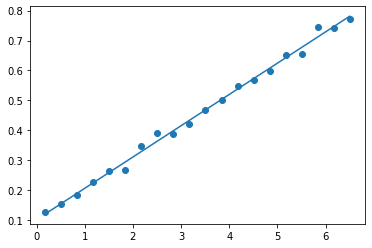

In [114]:
plt.scatter(x, y)

popt, pcov = curve_fit(linear_fit, x, y)

plt.plot(x, linear_fit(x, *popt))
print(popt)

In [43]:
log_file = pd.read_csv(run_dir+"log_file.csv")
ts_list = np.array(log_file['ts'].tolist())
ts = str(ts_list[33])

with open(run_dir+"LIsing_2D_input_"+ts+".pkl", "rb") as fp:   
    input_dict = pickle.load(fp)
        
with open(run_dir+"LIsing_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)
    
measure_list = input_dict['measure_list']
h_dist_dict, J_dist_dict = output_reader(measure_list, run_dir+"LIsing_2D_output_"+ts+".txt")
    

In [32]:
J_dist_dict[7][600]

array([], dtype=float64)

In [35]:
def get_length_scale(measure_list, h_dist_dict, J_dist_dict):
    Omega_list = []
    for i in range(len(measure_list)-3):
        inst_num_list = h_dist_dict[i].keys()
        Omegas = []
        for inst in inst_num_list:
            #print(i, inst)
            beta_max = max(h_dist_dict[i][inst])
            zeta_max = max(J_dist_dict[i][inst])
            Omegas.append(max(beta_max, zeta_max))
        Omega_list.append(Omegas)
    return np.array(Omega_list)



In [44]:
Omega_list = get_length_scale(measure_list, h_dist_dict, J_dist_dict)

[ 0.16431511 12.00291708]


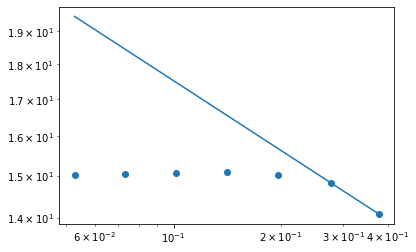

In [46]:
L = input_dict['L']
spins_left = L*L - measure_list
x_data = 1/(spins_left[:-3]**0.5)
y_data = Omega_list.mean(axis=1)
plt.scatter(x_data, y_data)

plt.yscale('log')
plt.xscale('log')

popt, pcov = curve_fit(power_law_scale, x_data[-2:], y_data[-2:])

print(popt)
plt.plot(x_data, power_law_scale(x_data, *popt))

In [49]:
L*L - gen_check_list(L*L, L*L-1, 10, 0.1)

array([3240, 3413, 3503, 3550, 3574, 3587, 3593, 3597, 3599, 3600])

In [6]:
L_list = [10, 20, 30, 40, 60]
w_vals_comp = []
log_gap_comp = []
log_gap_std_comp = []

for L in L_list: 
    log_file = pd.read_csv(run_dir+"log_file.csv")
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w'].tolist()
    
    average_log_gap = []
    log_gap_std = []
    
    for index, ts in enumerate(ts_list):
        with open(run_dir+"LIsing_2D_input_"+ts+".pkl", "rb") as fp:   
            input_dict = pickle.load(fp)

        #with open(run_dir+"LIsing_2D_clusters_"+ts+".pkl", "rb") as fp:   
        #    clust_list_final = pickle.load(fp)

        measure_list = input_dict['measure_list']
        h_dist_dict, J_dist_dict = output_reader(measure_list, run_dir+"LIsing_2D_output_"+ts+".txt")
    
        for i in range(1, len(measure_list)):
            if h_dist_dict[-i]=={}: continue
            else:
                log_gap_list = np.concatenate(tuple(h_dist_dict[-i].values()))
                break
        average_log_gap.append(log_gap_list.mean())
        log_gap_std.append(log_gap_list.std()/np.sqrt(960-1))
    
    w_vals_comp.append(w_vals)
    log_gap_comp.append(average_log_gap)
    log_gap_std_comp.append(log_gap_std)

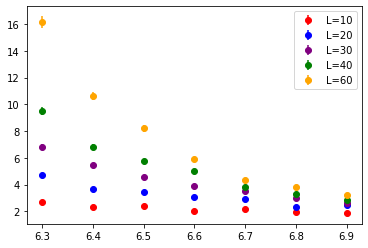

In [8]:
c_dict = {10:'red', 20:'blue', 40:'green', 60:'orange', 30:'purple'}

for ind, L in enumerate(L_list):
    plt.errorbar(w_vals_comp[ind], log_gap_comp[ind], yerr=np.array(log_gap_std_comp[ind]), c=c_dict[L], marker='o', linestyle='', label='L='+str(L))
    
#plt.yscale('log')
plt.legend()

6.3 [-1.15213799  0.14192048]
6.4 [-0.93671258  0.22568809]
6.5 [-0.76131067  0.35633757]
6.6 [-0.59645608  0.52431098]
6.7 [-0.38479333  0.91867918]
6.8 [-0.39060534  0.77083742]
6.9 [-0.28455027  1.00776043]


Text(0.5, 0, 'Linear System Size (L)')

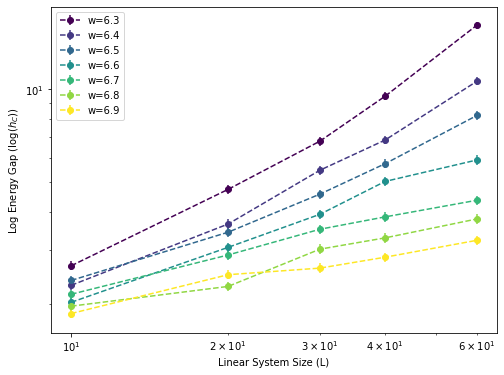

In [169]:
plt.figure(figsize=(8, 6))
norm = mpl.colors.Normalize(vmin=6.3, vmax=6.9)
cmap = 'viridis'#
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for w_ind in np.arange(6.3, 6.9, 0.1):
    w_ind = round(w_ind, 2)
    gap_list = []
    gap_err_list = []
    #if w_ind==6.3: continue
    #print(w_ind)
    c = m.cmap(norm(w_ind))
    for ind, L in enumerate(L_list):
        index = np.where(np.array(w_vals_comp[ind])==w_ind)[0][0]
        gap_list.append(log_gap_comp[ind][index])
        gap_err_list.append(log_gap_std_comp[ind][index])
    plt.errorbar(np.array(L_list), gap_list, yerr=gap_err_list, marker='o', linestyle='--', label="w="+str(w_ind), color=c)

    popt, pcov = curve_fit(power_law_scale, L_list[:], gap_list[:])
    print(w_ind, popt)
    #plt.plot(L_list, power_law_scale(L_list, *popt), c=c)
plt.yscale('log')
plt.xscale('log')
plt.legend()
#print(popt)
plt.ylabel(r"Log Energy Gap (log($h_C$))")
plt.xlabel("Linear System Size (L)")

In [138]:
w_vals_comp[0]

[6.4, 6.3, 6.5, 6.6, 6.7, 6.8, 6.9]